In [5]:
import pandas as pd
import numpy as np
import re
from scipy import stats
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [6]:
class MentalHealthJournalAnalyzer:
    """
    Analyzes journal entries for mental health indicators using dictionary-based approach.
    """
    
    def __init__(self):
        self.indicators = {
            'depression': {
                'negative_emotion': [
                    'sad', 'depressed', 'hopeless', 'empty', 'numb', 'worthless', 
                    'miserable', 'despair', 'unhappy', 'gloomy', 'blue', 'down'
                ],
                'anhedonia': [
                    "don't enjoy", "no pleasure", "lost interest", "nothing feels",
                    "don't care anymore", "no motivation", "pointless", "meaningless"
                ],
                'fatigue': [
                    'exhausted', 'tired', 'no energy', 'drained', "can't get up",
                    'too tired', 'fatigued', 'weary', 'sluggish', 'lethargic'
                ],
                'negative_self': [
                    'hate myself', "i'm worthless", "i'm useless", 'failure',
                    "i'm terrible", 'i suck', 'not good enough', 'disappointing'
                ]
            },
            'anxiety': {
                'worry': [
                    'worried', 'anxious', 'nervous', 'stressed', 'tense',
                    'on edge', 'uneasy', 'fearful', 'afraid', 'scared', 'panic'
                ],
                'rumination': [
                    "can't stop thinking", 'keep thinking', 'obsessing',
                    'replaying', 'what if', 'overthinking', "can't let go"
                ],
                'physical': [
                    'heart racing', "can't breathe", 'shaking', 'sweating',
                    'panic', 'chest tight', 'dizzy', 'nauseous'
                ]
            },
            'wellbeing': {
                'positive_emotion': [
                    'happy', 'joyful', 'excited', 'grateful', 'content',
                    'peaceful', 'proud', 'hopeful', 'glad', 'pleased', 'satisfied'
                ],
                'social_connection': [
                    'spent time with', 'talked to', 'connected', 'supported',
                    'loved', 'friendship', 'together', 'hang out', 'caught up'
                ],
                'achievement': [
                    'accomplished', 'achieved', 'succeeded', 'completed',
                    'proud of', 'did well', 'finished', 'made progress'
                ]
            },
            'coping': {
                'problem_solving': [
                    'i decided', 'i will', 'i plan to', "i'm going to",
                    'next time', 'i can', 'i should', 'i need to', 'my goal'
                ],
                'reframing': [
                    'realized', 'perspective', 'looking at it', 'another way',
                    'silver lining', 'learned', 'understand', 'makes sense'
                ],
                'support_seeking': [
                    'talked to', 'reached out', 'asked for help',
                    'shared with', 'told someone', 'opened up'
                ]
            },
            'risk': {
                'isolation': [
                    'alone', 'nobody', 'no one', 'isolated', 'withdrawn',
                    'by myself', 'lonely', 'disconnected'
                ],
                'self_harm': [
                    'hurt myself', 'cut', 'harm', 'deserve pain',
                    'punish myself', 'self-harm'
                ],
                'suicidal': [
                    'want to die', 'kill myself', 'end it all',
                    'better off dead', 'no point', 'suicide', 'not worth living'
                ]
            }
        }
        
    def preprocess_text(self, text):
        if pd.isna(text) or not isinstance(text, str):
            return ""
        text = text.lower()
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def count_pattern_matches(self, text, patterns):
        if not text:
            return 0
        count = 0
        for pattern in patterns:
            pattern_escaped = re.escape(pattern)
            regex = re.compile(r'\b' + pattern_escaped + r'\b', re.IGNORECASE)
            matches = regex.findall(text)
            count += len(matches)
        return count
    
    def calculate_linguistic_features(self, text):
        if not text:
            return {
                'word_count': 0, 'first_person_ratio': 0, 'second_person_ratio': 0,
                'third_person_ratio': 0, 'negation_ratio': 0, 'avg_word_length': 0
            }
            
        words = text.split()
        word_count = len(words)
        
        first_person = len(re.findall(r'\b(i|me|my|myself|mine|i\'m|i\'ve|i\'ll|i\'d)\b', 
                                       text, re.IGNORECASE))
        first_person_ratio = (first_person / word_count * 100) if word_count > 0 else 0
        
        second_person = len(re.findall(r'\b(you|your|yours|yourself)\b', 
                                        text, re.IGNORECASE))
        second_person_ratio = (second_person / word_count * 100) if word_count > 0 else 0
        
        third_person = len(re.findall(r'\b(he|she|they|him|her|them|his|hers|their)\b',
                                       text, re.IGNORECASE))
        third_person_ratio = (third_person / word_count * 100) if word_count > 0 else 0
        
        negations = len(re.findall(r'\b(no|not|never|nothing|nowhere|nobody|none|neither)\b',
                                    text, re.IGNORECASE))
        negation_ratio = (negations / word_count * 100) if word_count > 0 else 0
        
        avg_word_length = np.mean([len(word) for word in words]) if words else 0
        
        return {
            'word_count': word_count,
            'first_person_ratio': round(first_person_ratio, 2),
            'second_person_ratio': round(second_person_ratio, 2),
            'third_person_ratio': round(third_person_ratio, 2),
            'negation_ratio': round(negation_ratio, 2),
            'avg_word_length': round(avg_word_length, 2)
        }
    
    def detect_risk_flags(self, scores, linguistic_features):
        risk_flags = []
        
        if scores['risk']['suicidal']['count'] > 0:
            risk_flags.append({
                'level': 'CRITICAL', 'category': 'suicidal_ideation',
                'message': 'Suicidal ideation detected - immediate intervention needed',
                'count': scores['risk']['suicidal']['count']
            })
        
        if scores['risk']['self_harm']['count'] > 0:
            risk_flags.append({
                'level': 'HIGH', 'category': 'self_harm',
                'message': 'Self-harm language detected',
                'count': scores['risk']['self_harm']['count']
            })
        
        if (scores['risk']['isolation']['count'] >= 2 and 
            scores['wellbeing']['social_connection']['count'] == 0):
            risk_flags.append({
                'level': 'MODERATE', 'category': 'social_isolation',
                'message': 'Social isolation pattern detected',
                'count': scores['risk']['isolation']['count']
            })
        
        depression_total = sum(scores['depression'][k]['count'] for k in scores['depression'])
        coping_total = sum(scores['coping'][k]['count'] for k in scores['coping'])
        
        if depression_total >= 5 and coping_total == 0:
            risk_flags.append({
                'level': 'MODERATE', 'category': 'depression_no_coping',
                'message': 'High depression markers with no coping strategies evident',
                'count': depression_total
            })
        
        return risk_flags
    
    def analyze_entry(self, text, entry_id=None, metadata=None):
        processed_text = self.preprocess_text(text)
        linguistic_features = self.calculate_linguistic_features(processed_text)
        word_count = linguistic_features['word_count']
        
        scores = {}
        for category, subcategories in self.indicators.items():
            scores[category] = {}
            for subcategory, patterns in subcategories.items():
                count = self.count_pattern_matches(processed_text, patterns)
                percentage = (count / word_count * 100) if word_count > 0 else 0
                scores[category][subcategory] = {
                    'count': count,
                    'percentage': round(percentage, 2)
                }
        
        composite = {
            'depression': sum(scores['depression'][k]['count'] for k in scores['depression']),
            'anxiety': sum(scores['anxiety'][k]['count'] for k in scores['anxiety']),
            'wellbeing': sum(scores['wellbeing'][k]['count'] for k in scores['wellbeing']),
            'coping': sum(scores['coping'][k]['count'] for k in scores['coping']),
            'risk': sum(scores['risk'][k]['count'] for k in scores['risk'])
        }
        
        risk_flags = self.detect_risk_flags(scores, linguistic_features)
        
        return {
            'entry_id': entry_id,
            'metadata': metadata or {},
            'linguistic_features': linguistic_features,
            'scores': scores,
            'composite': composite,
            'risk_flags': risk_flags,
            'timestamp': datetime.now().isoformat()
        }
    
    def analyze_batch(self, df, text_column='text', id_column=None, metadata_columns=None):
        results = []
        
        for idx, row in df.iterrows():
            entry_id = row[id_column] if id_column and id_column in df.columns else idx
            metadata = {col: row[col] for col in metadata_columns} if metadata_columns else {}
            
            analysis = self.analyze_entry(
                text=row[text_column],
                entry_id=entry_id,
                metadata=metadata
            )
            
            flat_result = {
                'entry_id': analysis['entry_id'],
                **analysis['linguistic_features'],
                **{f'composite_{k}': v for k, v in analysis['composite'].items()},
                'risk_flag_count': len(analysis['risk_flags']),
                'highest_risk_level': analysis['risk_flags'][0]['level'] if analysis['risk_flags'] else 'NONE'
            }
            
            for category, subcats in analysis['scores'].items():
                for subcat, values in subcats.items():
                    flat_result[f'{category}_{subcat}_count'] = values['count']
                    flat_result[f'{category}_{subcat}_pct'] = values['percentage']
            
            flat_result.update(metadata)
            results.append(flat_result)
        
        return pd.DataFrame(results)


In [7]:
print("="*70)
print("MENTAL HEALTH JOURNAL ANALYSIS")
print("="*70)

# Step 1: Load your data
print("\n[1/5] Loading data...")
df = pd.read_csv("journal_emotion.csv")
print(f"✓ Loaded {len(df)} journal entries")
print(f"   Columns: {df.columns.tolist()}")

# Detect column names
text_col = 'text' if 'text' in df.columns else 'data' if 'data' in df.columns else df.columns[0]
condition_col = 'condition' if 'condition' in df.columns else 'phase' if 'phase' in df.columns else None
week_col = 'week' if 'week' in df.columns else 'week_per_uid' if 'week_per_uid' in df.columns else None
participant_col = 'participant_id' if 'participant_id' in df.columns else 'uid' if 'uid' in df.columns else None

print(f"\n   Using columns:")
print(f"   - Text: '{text_col}'")
print(f"   - Condition: '{condition_col}'")
print(f"   - Week: '{week_col}'")
print(f"   - Participant: '{participant_col}'")


MENTAL HEALTH JOURNAL ANALYSIS

[1/5] Loading data...
✓ Loaded 603 journal entries
   Columns: ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'data', 'day', 'uid', 'week_per_uid', 'sentiment', 'phase', 'top_emotion', 'top_emotion_score', 'all_top_emotions']

   Using columns:
   - Text: 'data'
   - Condition: 'phase'
   - Week: 'week_per_uid'
   - Participant: 'uid'


In [8]:
# Step 2: Initialize analyzer and process data
print("\n[2/5] Analyzing journal entries...")
analyzer = MentalHealthJournalAnalyzer()

metadata_cols = [col for col in [condition_col, week_col, participant_col] if col]

results = analyzer.analyze_batch(
    df,
    text_column=text_col,
    metadata_columns=metadata_cols if metadata_cols else None
)

print("✓ Analysis complete!")
print(f"   Processed {len(results)} entries")

print("\n   Sample results:")
print(
    results[
        ['entry_id', 'word_count',
         'composite_depression', 'composite_anxiety',
         'composite_wellbeing', 'composite_coping']
    ].head()
)



[2/5] Analyzing journal entries...
✓ Analysis complete!
   Processed 603 entries

   Sample results:
   entry_id  word_count  composite_depression  composite_anxiety  \
0         0          68                     0                  0   
1         1          76                     0                  0   
2         2          60                     0                  0   
3         3          56                     1                  0   
4         4          98                     0                  1   

   composite_wellbeing  composite_coping  
0                    0                 0  
1                    0                 0  
2                    0                 0  
3                    0                 0  
4                    0                 1  



[3/5] RQ1: Do contextual prompts lead to better mental health indicators?

Sample sizes: Contextual=537, Generic=60

    Metric Contextual M(SD) Generic M(SD)      t     p      d Sig
Depression      0.10 (0.33)   0.20 (0.44) -2.149 0.032 -0.258   *
   Anxiety      0.05 (0.22)   0.07 (0.25) -0.663 0.508 -0.085  ns
 Wellbeing      0.17 (0.45)   0.20 (0.55) -0.516 0.606 -0.065  ns
    Coping      0.23 (0.53)   0.18 (0.57)  0.632 0.527  0.084  ns

Note: *** p<.001, ** p<.01, * p<.05, ns=not significant


/Users/nadiamehjabin/anaconda3/envs/mindscape/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 88.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiamehjabin/anaconda3/envs/mindscape/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiamehjabin/anaconda3/envs/mindscape/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 87.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiamehjabin/anaconda3/envs/mindscape/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings


✓ Visualization saved as 'rq1_comparison.png'


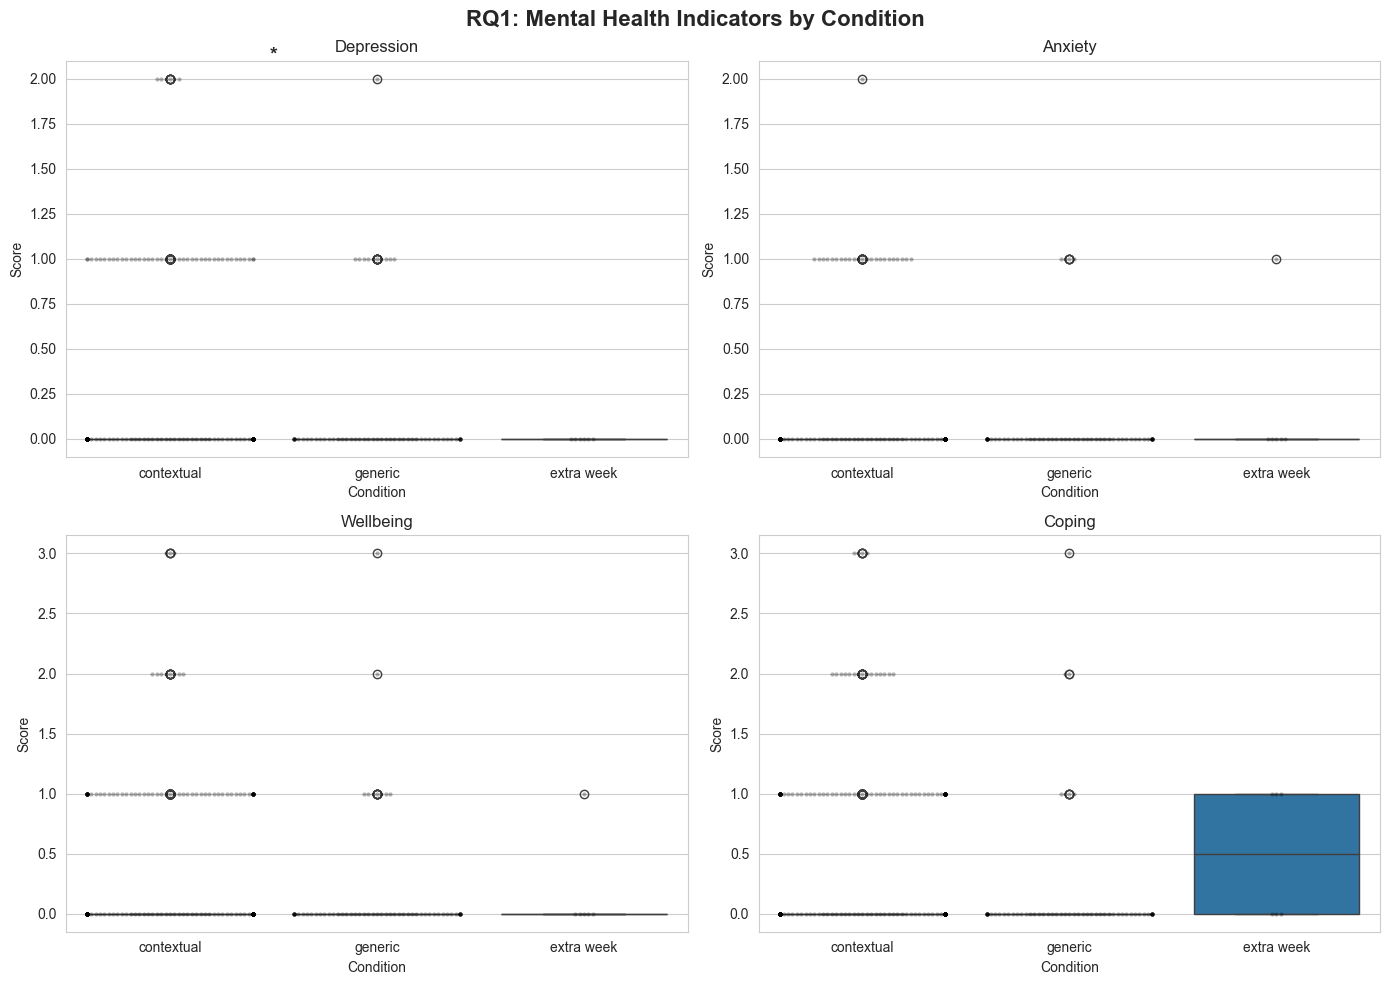

In [9]:
# Step 3: RQ1 - Contextual vs Generic comparison
if condition_col:
    print("\n" + "="*70)
    print("[3/5] RQ1: Do contextual prompts lead to better mental health indicators?")
    print("="*70)
    
    contextual = results[results[condition_col] == 'contextual']
    generic = results[results[condition_col] == 'generic']
    
    print(f"\nSample sizes: Contextual={len(contextual)}, Generic={len(generic)}")
    
    rq1_data = []
    metrics = ['composite_depression', 'composite_anxiety',
               'composite_wellbeing', 'composite_coping']
    
    for metric in metrics:
        t_stat, p_value = stats.ttest_ind(contextual[metric], generic[metric])
        cohen_d = (contextual[metric].mean() - generic[metric].mean()) / \
                  np.sqrt((contextual[metric].std()**2 + generic[metric].std()**2) / 2)
        
        rq1_data.append({
            'Metric': metric.replace('composite_', '').title(),
            'Contextual M(SD)': f"{contextual[metric].mean():.2f} ({contextual[metric].std():.2f})",
            'Generic M(SD)': f"{generic[metric].mean():.2f} ({generic[metric].std():.2f})",
            't': f"{t_stat:.3f}",
            'p': f"{p_value:.3f}",
            'd': f"{cohen_d:.3f}",
            'Sig': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
        })
    
    rq1_table = pd.DataFrame(rq1_data)
    print("\n" + rq1_table.to_string(index=False))
    print("\nNote: *** p<.001, ** p<.01, * p<.05, ns=not significant")
    
    # Visualization for RQ1
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('RQ1: Mental Health Indicators by Condition', fontsize=16, fontweight='bold')
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        data_to_plot = results[[condition_col, metric]].copy()
        sns.boxplot(x=condition_col, y=metric, data=data_to_plot, ax=ax)
        sns.swarmplot(x=condition_col, y=metric, data=data_to_plot,
                      ax=ax, color='black', alpha=0.3, size=3)
        
        p_val = float(rq1_data[idx]['p'])
        sig = rq1_data[idx]['Sig']
        if sig != 'ns':
            y_max = data_to_plot[metric].max()
            ax.text(0.5, y_max * 1.05, sig, ha='center', fontsize=14, fontweight='bold')
        
        ax.set_title(metric.replace('composite_', '').title())
        ax.set_xlabel('Condition')
        ax.set_ylabel('Score')
    
    plt.tight_layout()
    plt.savefig('rq1_comparison.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved as 'rq1_comparison.png'")
    plt.show()



[4/5] RQ2: Do users show improvement over the 8 weeks?

CONTEXTUAL Condition:
  composite_depression: slope=0.004, R²=0.108, p=0.524 [worsening]
  composite_anxiety: slope=0.009, R²=0.406, p=0.174 [worsening]
  composite_wellbeing: slope=0.001, R²=0.011, p=0.844 [IMPROVING]
  composite_coping: slope=-0.022, R²=0.474, p=0.130 [worsening]

GENERIC Condition:
  composite_depression: slope=-0.255, R²=1.000, p=0.000 [IMPROVING]
  composite_anxiety: slope=-0.085, R²=1.000, p=0.000 [IMPROVING]
  composite_wellbeing: slope=0.432, R²=1.000, p=0.000 [IMPROVING]
  composite_coping: slope=-0.234, R²=1.000, p=0.000 [worsening]

EXTRA WEEK Condition:
  composite_depression: slope=nan, R²=0.000, p=nan [worsening]
  composite_anxiety: slope=nan, R²=0.000, p=nan [worsening]
  composite_wellbeing: slope=nan, R²=0.000, p=nan [worsening]
  composite_coping: slope=nan, R²=0.000, p=nan [worsening]

 Condition     Metric  Slope Direction    R²     p     Trend
contextual Depression  0.004         ↑ 0.108 0.5

/Users/nadiamehjabin/anaconda3/envs/mindscape/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/Users/nadiamehjabin/anaconda3/envs/mindscape/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/nadiamehjabin/anaconda3/envs/mindscape/lib/python3.10/site-packages/scipy/stats/_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)



✓ Visualization saved as 'rq2_trends.png'


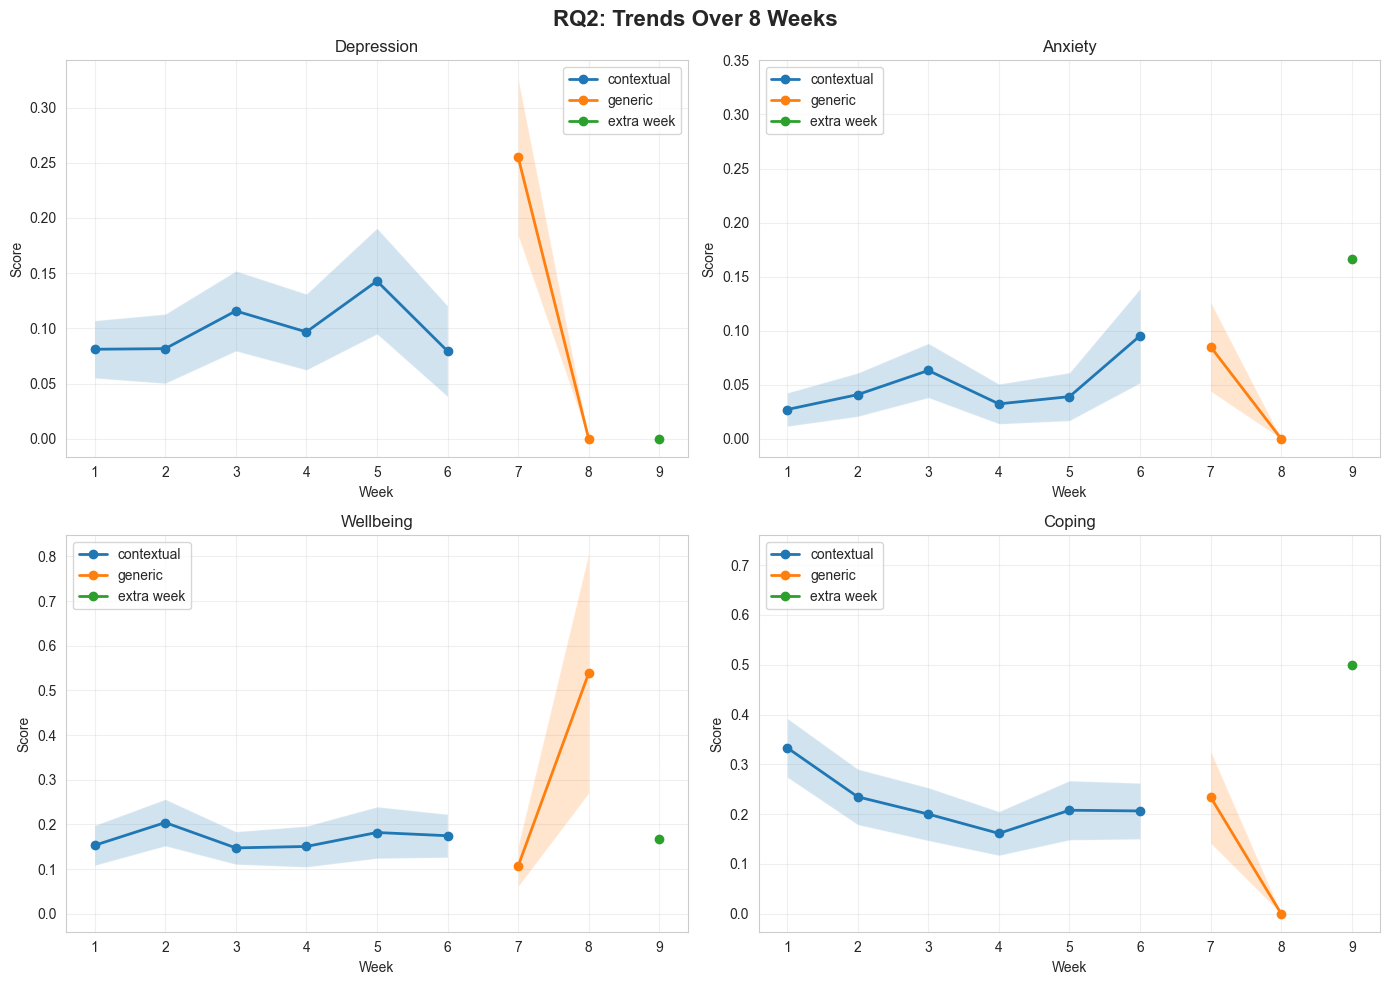

In [10]:
# Step 4: RQ2 - Improvement over time
if week_col and condition_col:
    print("\n" + "="*70)
    print("[4/5] RQ2: Do users show improvement over the 8 weeks?")
    print("="*70)
    
    rq2_data = []
    
    for condition in results[condition_col].unique():
        condition_data = results[results[condition_col] == condition]
        weekly_means = condition_data.groupby(week_col).agg({
            'composite_depression': 'mean',
            'composite_anxiety': 'mean',
            'composite_wellbeing': 'mean',
            'composite_coping': 'mean'
        })
        
        print(f"\n{condition.upper()} Condition:")
        
        for metric in metrics:
            slope, intercept, r_value, p_value, std_err = linregress(
                weekly_means.index, weekly_means[metric]
            )
            
            improving = (slope < 0 and metric in ['composite_depression', 'composite_anxiety']) or \
                        (slope > 0 and metric in ['composite_wellbeing', 'composite_coping'])
            
            direction = "↓" if slope < 0 else "↑"
            trend = "IMPROVING" if improving else "worsening"
            
            rq2_data.append({
                'Condition': condition,
                'Metric': metric.replace('composite_', '').title(),
                'Slope': f"{slope:.3f}",
                'Direction': direction,
                'R²': f"{r_value**2:.3f}",
                'p': f"{p_value:.3f}",
                'Trend': trend
            })
            
            print(f"  {metric}: slope={slope:.3f}, R²={r_value**2:.3f}, p={p_value:.3f} [{trend}]")
    
    rq2_table = pd.DataFrame(rq2_data)
    print("\n" + rq2_table.to_string(index=False))
    
    # Visualization for RQ2
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('RQ2: Trends Over 8 Weeks', fontsize=16, fontweight='bold')
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        
        for condition in results[condition_col].unique():
            condition_data = results[results[condition_col] == condition]
            weekly_means = condition_data.groupby(week_col)[metric].mean()
            weekly_sem = condition_data.groupby(week_col)[metric].sem()
            
            ax.plot(weekly_means.index, weekly_means.values, marker='o',
                    label=condition, linewidth=2)
            ax.fill_between(
                weekly_means.index,
                weekly_means.values - weekly_sem.values,
                weekly_means.values + weekly_sem.values,
                alpha=0.2
            )
        
        ax.set_title(metric.replace('composite_', '').title())
        ax.set_xlabel('Week')
        ax.set_ylabel('Score')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('rq2_trends.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved as 'rq2_trends.png'")
    plt.show()



[5/5] RQ3: Are contextual prompts associated with more coping strategies?

Overall Coping:
  Contextual: M=0.23, SD=0.53
  Generic:    M=0.18, SD=0.57
  t=0.632, p=0.527
  Not significant

Coping Strategy Breakdown:
  problem_solving: Contextual=0.18, Generic=0.15, p=0.657
  reframing: Contextual=0.04, Generic=0.03, p=0.884
  support_seeking: Contextual=0.01, Generic=0.00, p=0.375

    Coping Type Contextual M(SD) Generic M(SD)     t     p Sig
Problem Solving      0.18 (0.47)   0.15 (0.52) 0.445 0.657  ns
      Reframing      0.04 (0.20)   0.03 (0.18) 0.146 0.884  ns
Support Seeking      0.01 (0.11)   0.00 (0.00) 0.889 0.375  ns


/Users/nadiamehjabin/anaconda3/envs/mindscape/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 85.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiamehjabin/anaconda3/envs/mindscape/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiamehjabin/anaconda3/envs/mindscape/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 81.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nadiamehjabin/anaconda3/envs/mindscape/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 23.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings


✓ Visualization saved as 'rq3_coping.png'


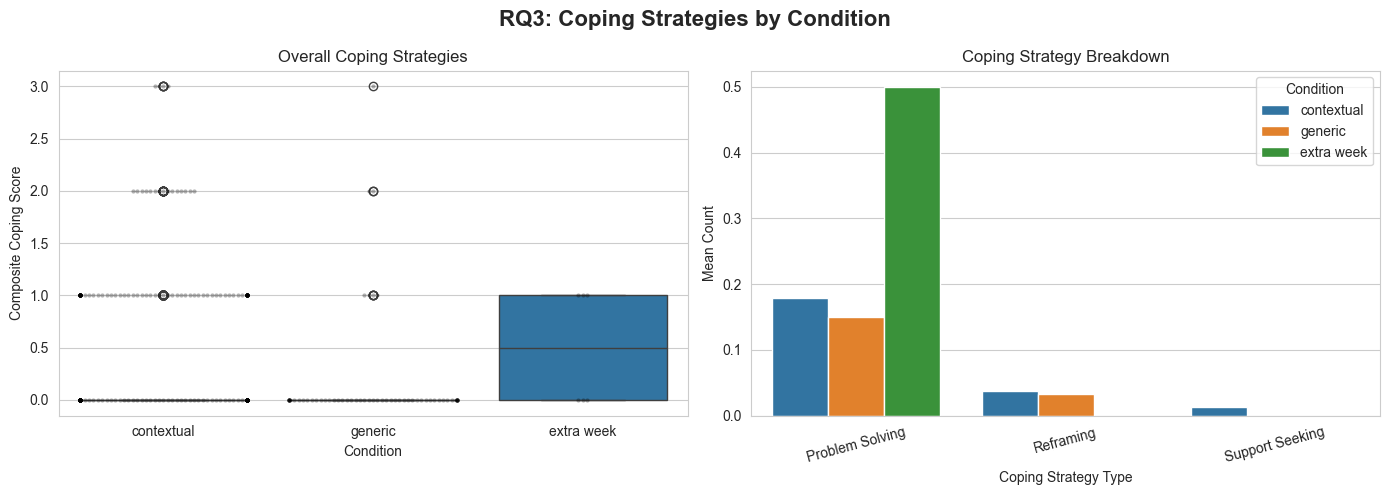

In [11]:
# Step 5: RQ3 - Coping strategies
if condition_col:
    print("\n" + "="*70)
    print("[5/5] RQ3: Are contextual prompts associated with more coping strategies?")
    print("="*70)
    
    # Overall coping
    t_stat, p_value = stats.ttest_ind(
        contextual['composite_coping'],
        generic['composite_coping']
    )
    
    print("\nOverall Coping:")
    print(f"  Contextual: M={contextual['composite_coping'].mean():.2f}, SD={contextual['composite_coping'].std():.2f}")
    print(f"  Generic:    M={generic['composite_coping'].mean():.2f}, SD={generic['composite_coping'].std():.2f}")
    print(f"  t={t_stat:.3f}, p={p_value:.3f}")
    print(f"  {'*** SIGNIFICANT ***' if p_value < 0.05 else 'Not significant'}")
    
    # Coping subtypes
    print("\nCoping Strategy Breakdown:")
    rq3_data = []
    coping_types = ['problem_solving', 'reframing', 'support_seeking']
    
    for coping_type in coping_types:
        col_name = f'coping_{coping_type}_count'
        ctx_mean = contextual[col_name].mean()
        ctx_std = contextual[col_name].std()
        gen_mean = generic[col_name].mean()
        gen_std = generic[col_name].std()
        t_stat, p_value = stats.ttest_ind(contextual[col_name], generic[col_name])
        
        rq3_data.append({
            'Coping Type': coping_type.replace('_', ' ').title(),
            'Contextual M(SD)': f"{ctx_mean:.2f} ({ctx_std:.2f})",
            'Generic M(SD)': f"{gen_mean:.2f} ({gen_std:.2f})",
            't': f"{t_stat:.3f}",
            'p': f"{p_value:.3f}",
            'Sig': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
        })
        
        print(f"  {coping_type}: Contextual={ctx_mean:.2f}, Generic={gen_mean:.2f}, p={p_value:.3f}")
    
    rq3_table = pd.DataFrame(rq3_data)
    print("\n" + rq3_table.to_string(index=False))
    
    # Visualization for RQ3
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('RQ3: Coping Strategies by Condition', fontsize=16, fontweight='bold')
    
    # Overall coping
    sns.boxplot(x=condition_col, y='composite_coping', data=results, ax=ax1)
    sns.swarmplot(x=condition_col, y='composite_coping', data=results,
                  ax=ax1, color='black', alpha=0.3, size=3)
    ax1.set_title('Overall Coping Strategies')
    ax1.set_xlabel('Condition')
    ax1.set_ylabel('Composite Coping Score')
    
    # Coping subtypes
    coping_means = []
    for condition in results[condition_col].unique():
        cond_data = results[results[condition_col] == condition]
        for coping_type in coping_types:
            coping_means.append({
                'Condition': condition,
                'Coping Type': coping_type.replace('_', ' ').title(),
                'Mean': cond_data[f'coping_{coping_type}_count'].mean()
            })
    
    coping_df = pd.DataFrame(coping_means)
    sns.barplot(x='Coping Type', y='Mean', hue='Condition', data=coping_df, ax=ax2)
    ax2.set_title('Coping Strategy Breakdown')
    ax2.set_xlabel('Coping Strategy Type')
    ax2.set_ylabel('Mean Count')
    ax2.legend(title='Condition')
    plt.xticks(rotation=15)
    
    plt.tight_layout()
    plt.savefig('rq3_coping.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved as 'rq3_coping.png'")
    plt.show()


In [12]:
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

results.to_csv('mental_health_analysis_results.csv', index=False)
print("✓ Full results saved to 'mental_health_analysis_results.csv'")

if condition_col:
    rq1_table.to_csv('rq1_results.csv', index=False)
    print("✓ RQ1 table saved to 'rq1_results.csv'")
    
if week_col and condition_col:
    rq2_table.to_csv('rq2_results.csv', index=False)
    print("✓ RQ2 table saved to 'rq2_results.csv'")
    
if condition_col:
    rq3_table.to_csv('rq3_results.csv', index=False)
    print("✓ RQ3 table saved to 'rq3_results.csv'")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print("\nGenerated files:")
print("  - mental_health_analysis_results.csv (full data)")
print("  - rq1_results.csv (condition comparison)")
print("  - rq2_results.csv (temporal trends)")
print("  - rq3_results.csv (coping strategies)")
print("  - rq1_comparison.png (visualization)")
print("  - rq2_trends.png (visualization)")
print("  - rq3_coping.png (visualization)")



SAVING RESULTS
✓ Full results saved to 'mental_health_analysis_results.csv'
✓ RQ1 table saved to 'rq1_results.csv'
✓ RQ2 table saved to 'rq2_results.csv'
✓ RQ3 table saved to 'rq3_results.csv'

ANALYSIS COMPLETE!

Generated files:
  - mental_health_analysis_results.csv (full data)
  - rq1_results.csv (condition comparison)
  - rq2_results.csv (temporal trends)
  - rq3_results.csv (coping strategies)
  - rq1_comparison.png (visualization)
  - rq2_trends.png (visualization)
  - rq3_coping.png (visualization)
